# **METAMODELING WITH ARTIFICIAL NEURAL NETWORK**

In this notebook, we will use the results of Abaqus analyses in order to build an Artificial Neural Network (ANN) of the Finite Element (FE) analysis solver.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import sys
import os

In [2]:
# Scikit-learn
from sklearn.model_selection import train_test_split

# PyTorch
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

# Matplotlib spec
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']}) # Palatino font
plt.rcParams['pdf.fonttype'] = 42

In [3]:
torch.__version__

'1.5.1'

When this notebook has been generated the result of the previous line of code is: _'1.5.0'_

We fix the seed in order to obtain reproducible results.

__N.B.__ : Reproducible results are obtained every time the runtime is restarded and runned. If you run multiple time the same cell the results will not be reporducible.

In [4]:
seed = 0
np.random.seed(seed=seed)
torch.manual_seed(seed=seed)
random.seed(seed)

# Last two lines just when using GPU
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(seed=seed)

## **Data preprocessing**

We start by importing some information about the model used to generate the dataset.

In [5]:
# Modify parameter to choose the output folder to consider
load_case = 'axial'
stacking_sequence = 'symmetric_balanced'
data_set = '2x'
fiber_path = 'harmlin'

# Check if notebook running in Colab
is_colab = 'google.colab' in sys.modules

# Model info folder
if is_colab:
    input_folder = './'
else:
    input_folder = load_case + '/' + stacking_sequence + '/' + data_set + '/' + fiber_path + '/'

info = pd.read_csv(input_folder + 'model_info.csv', sep=",")
info.index = ['Value']
eff_plies = int(info['EffectivePlies'].values)
info.head()

,Height,Radius,MaxCurvature,MeshSize,Plies,EffectivePlies,Symmetric,Balanced,AnglesFunction,LoadCase,Train,Test
Value,705,300,0.001575,10,8,2,True,True,harmlin,axial,128,32


In [6]:
sets = ['Train', 'Val', 'Test']
for set in sets:
    if set not in info.keys():
        sets.remove(set)
print("Active sets: {}, {}".format(*sets))

Active sets: Train, Test


At this point we have to import the data set containing the input and output of the FE analysis. The data is stored in a dataframe in which the upper part is associated to the training set and the lower part to the test set. The precise number of upper row belonging to the train set is indicated in the info above.

In [7]:
# Import data sets
data_orig = pd.read_csv(input_folder + '/data.csv', sep=',')
data_orig.describe()

,Amplitude1,PhaseShift1,Omega1,Beta1,Amplitude2,PhaseShift2,Omega2,Beta2,Buckling,Stiffness
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,2.070144,0.031938,1.000456,0.032338,-3.336031,-0.020719,1.000194,0.049800,252.621775,187.829000
std,81.223350,52.161625,0.577993,52.171156,80.082929,52.176463,0.579600,52.098908,39.743864,115.880896
min,-187.912000,-89.231000,0.015000,-88.995000,-199.306000,-88.775000,0.003000,-88.708000,160.299000,39.916000
25%,-39.162750,-44.880750,0.502250,-44.385000,-46.642000,-44.468000,0.497750,-44.799000,224.361750,83.257500
50%,0.754500,-0.406500,0.998500,-0.228000,0.875000,-0.112000,0.997500,0.022000,248.001000,183.254500
75%,44.945250,44.462500,1.493500,44.900000,38.226000,44.772250,1.498750,44.608750,280.917750,277.347500
max,180.930000,89.234000,1.989000,89.492000,195.404000,89.547000,1.984000,89.553000,362.584000,535.513000


The most important step to perform before training our model is the normalization of the variables. Different strategies are possible at this end, among which 2 are the most used:

* Range normalization: converts all the values to the range $[0, 1]$

* Standard score normalization: forces the variables to have $0$ mean and $1$ standard deviation

We will try both to see the effect on the model performance.

In [8]:
def range_norm(x, x_min=None, x_max=None):
    """ Normalization in range [0, 1] """
    if x_min is None and x_max is None:
        x_min = np.min(x, axis=0)
        x_max = np.max(x, axis=0)
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm, x_min, x_max

def std_norm(x, m=None, s=None):
    """ Normalization with zero mean and unitary standard deviation """
    if m is None and s is None:
        m = np.mean(x, axis=0)
        s = np.std(x, axis=0)
    x_norm = (x - m) / s
    
    return x_norm, m, s

Now we can split the data into training and test set. The two sets have been generate independently during the DOE.

In [9]:
X = data_orig.drop(['Buckling', 'Stiffness'], axis=1).values
Y = data_orig[['Buckling','Stiffness']].values

# Train set
train_smp = int(info['Train'].values)
_X_train = X[:train_smp, :]
_Y_train = Y[:train_smp]
last = np.copy(train_smp)

# Validation set
if 'Val' in sets:
    val_smp = int(info['Val'].values)
    _X_val = X[last:last+val_smp, :]
    _Y_val = Y[last:last+val_smp]
    last += val_smp

# Test set
if 'Test' in sets:
    test_smp = int(info['Test'].values)
    _X_test = X[last:last+test_smp, :]
    _Y_test = Y[last:last+test_smp]

If validation set is not present we will generate it from the training set.

In [10]:
_X_train, _X_val, _Y_train, _Y_val = train_test_split(_X_train, _Y_train, test_size=0.2, random_state=seed)
print('            Data sets info: \n')
print("X_train : {}  |  Y_train : {}".format(_X_train.shape, _Y_train.shape))
print("X_val   : {}   |  Y_val   : {}".format(_X_val.shape, _Y_val.shape))
print("X_test  : {}  |  Y_test  : {} \n".format(_X_test.shape, _Y_test.shape))

            Data sets info: 

X_train : (102, 8)  |  Y_train : (102, 2)
X_val   : (26, 8)   |  Y_val   : (26, 2)
X_test  : (32, 8)  |  Y_test  : (32, 2) 



At this point we can generate the iterable data sets for Torch

In [11]:
def shuffle_data(X, Y):
    """ Random shuffle of samples in X and y """
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    
    return X[idx], Y[idx]

In [12]:
# Normalization training set
X_train, x_min, x_max = range_norm(_X_train)
Y_train, y_min, y_max = range_norm(_Y_train)

# Shuffle training set
X_train, Y_train = shuffle_data(X_train, Y_train)

In [13]:
# Normalization validation set
X_val, _, _ = range_norm(_X_val, x_min=x_min, x_max=x_max)
Y_val, _, _ = range_norm(_Y_val, x_min=y_min, x_max=y_max)

# Normalization testing set
X_test, _, _ = range_norm(_X_test, x_min=x_min, x_max=x_max)
Y_test, _, _ = range_norm(_Y_test, x_min=y_min, x_max=y_max)

In [14]:
def create_batches(_X, _Y, batch_size):
    """ Split the data into k batches """

    n_samples = _X.shape[0]
    leftovers = {}
    n_leftovers = n_samples % batch_size
    
    # Case with all batches of equal size
    if n_leftovers != 0:
        leftovers["X"] = _X[-n_leftovers:]
        leftovers["Y"] = _Y[-n_leftovers:]
        _X = _X[:-n_leftovers]
        _Y = _Y[:-n_leftovers]

    k = np.int(_X.shape[0] / batch_size)
        
    X_split = np.split(_X, k)
    Y_split = np.split(_Y, k)
    
    # Add leftover samples as last batch
    if n_leftovers != 0:
        X_split.append(leftovers["X"])
        Y_split.append(leftovers["Y"])

    return X_split, Y_split

In [15]:
batch_size = 8
X_train_b, Y_train_b = create_batches(X_train, Y_train, batch_size=batch_size)

In [16]:
print("Batches dimensions: \n")
for i in range(len(X_train_b)):
    print("Batch {} : input {}  ,  output : {}".format(i, X_train_b[i].shape, Y_train_b[i].shape))

Batches dimensions: 

Batch 0 : input (8, 8)  ,  output : (8, 2)
Batch 1 : input (8, 8)  ,  output : (8, 2)
Batch 2 : input (8, 8)  ,  output : (8, 2)
Batch 3 : input (8, 8)  ,  output : (8, 2)
Batch 4 : input (8, 8)  ,  output : (8, 2)
Batch 5 : input (8, 8)  ,  output : (8, 2)
Batch 6 : input (8, 8)  ,  output : (8, 2)
Batch 7 : input (8, 8)  ,  output : (8, 2)
Batch 8 : input (8, 8)  ,  output : (8, 2)
Batch 9 : input (8, 8)  ,  output : (8, 2)
Batch 10 : input (8, 8)  ,  output : (8, 2)
Batch 11 : input (8, 8)  ,  output : (8, 2)
Batch 12 : input (6, 8)  ,  output : (6, 2)


In [119]:
class EarlyStopping:
    """ Stop network training if validation loss increases for a certain time.
        The code is base on https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py"""
    def __init__(self, patience=30, path='weights_NN'):
        self.patience = patience
        self.counter = 0
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path

    def __call__(self, val_loss, model):

        if self.val_loss_min > val_loss:
            self.val_loss_min = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

## **Neural network**

First define network class

In [134]:
class FFNN(torch.nn.Module):
    """ Implementation of FeedForward Neural Network """
    def __init__(self, D_in, H, D_out, p):
        super(FFNN, self).__init__()
        # First hidden layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(H, D_in)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(H), 0))
        # Second hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(H, H)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(H), 0))
        # Third hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(H, H)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(H), 0))
        # Output layer
        self.W_4 = Parameter(init.xavier_normal_(torch.Tensor(D_out, H)))
        self.b_4 = Parameter(init.constant_(torch.Tensor(D_out), 0))
        
        # define activation function in constructor
        self.activation_1 = torch.nn.ReLU()
        self.activation_2 = torch.nn.ReLU()
        self.activation_3 = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=p)

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation_1(x)
        x = self.dropout(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation_2(x)
        x = self.dropout(x)
        x = F.linear(x, self.W_3, self.b_3)
        x = self.activation_3(x)
        x = self.dropout(x)
        pred = F.linear(x, self.W_4, self.b_4)
        return pred

In [148]:
n_x = X_train.shape[1]
n_y = Y_train.shape[1]
D_in, H, D_out = n_x, 32, n_y

epochs = 10000
lr = 1e-4
weight_decay = 0.
lambda_1 = 1e-3
lambda_2 = 1e-5
p = 0.5
patience = 3000

model = FFNN(D_in, H, D_out, p)

early_stopping = EarlyStopping(patience=patience)

# Flag True if you are in the network optimization process.
is_optimizing = True

# If weight_NN exists and we are not in optimization mode just load
# network weights and evaluate the model.
if(os.path.isfile('weights_NN') and is_optimizing==False):
    model.load_state_dict(torch.load('weights_NN'))
    print(model.eval())
else:
    criterion = nn.MSELoss(reduction='mean') 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Initialize losses lists.
    train_loss = []
    val_loss = []
    losses = []
    W_1_hist = []
    W_2_hist = []
    W_3_hist = []
    
    idx = np.arange(len(X_train_b))
    
    for epoch in range(epochs):
        curr_loss = 0
        np.random.shuffle(idx)
        
        model.train()
        for batch_num in idx:
            
            # Create torch variables, required dtype 'float32' no 'float64'
            batch_x = Variable(torch.from_numpy(X_train_b[batch_num].astype('float32')))
            batch_y = Variable(torch.from_numpy(Y_train_b[batch_num].astype('float32')))
            optimizer.zero_grad()
            
            y_pred = model(batch_x)
            
            # L1 and L2 regularization
            l1_reg = None
            l2_reg = None
            for W in model.parameters():
                if l1_reg is None:
                    l1_reg = W.norm(1)
                    l2_reg = 0.5* W.norm(2) ** 2
                else:
                    l1_reg = l1_reg + W.norm(1)
                    l2_reg = l2_reg + 0.5 * W.norm(2) ** 2
                
            # Compute loss
            batch_loss = 1 / batch_x.shape[0] * ((y_pred - batch_y).pow(2).sum() + l1_reg * lambda_1 + l2_reg * lambda_2)
            batch_loss.backward()

            # Update weights
            optimizer.step()
            
            curr_loss += batch_loss
        train_loss.append(curr_loss.item() / len(idx))
        
        # Save norm of the weights
        W_1_hist.append(np.linalg.norm(model.W_1.detach().numpy()))
        W_2_hist.append(np.linalg.norm(model.W_2.detach().numpy()))
        W_3_hist.append(np.linalg.norm(model.W_3.detach().numpy()))
        
        model.eval()
        val_x = Variable(torch.from_numpy(X_val.astype('float32')))
        val_y = Variable(torch.from_numpy(Y_val.astype('float32')))
        val_pred = model(val_x)
        loss_val = 1 / val_x.shape[0] * ((val_y - val_pred).pow(2).sum() + l1_reg * lambda_1 + l2_reg * lambda_2)
            
        val_loss.append(loss_val.item())

        if epoch % 100 == 0:
            print("Iteration : {:04d} | Train loss : {:.5f} | Val loss : {:.5f}".format(epoch, train_loss[epoch], val_loss[epoch]))
        
        early_stopping(val_loss[epoch], model)
        
        if early_stopping.early_stop:
            print("\nEarly stopping - Minimum loss : {:.5f}".format(early_stopping.val_loss_min))
            break
    
    if not early_stopping.early_stop:
        torch.save(model.state_dict(), 'weights_NN')

Iteration : 0000 | Train loss : 0.58370 | Val loss : 0.26036
Iteration : 0100 | Train loss : 0.20426 | Val loss : 0.24594
Iteration : 0200 | Train loss : 0.17710 | Val loss : 0.19058
Iteration : 0300 | Train loss : 0.15079 | Val loss : 0.16629
Iteration : 0400 | Train loss : 0.14910 | Val loss : 0.15567
Iteration : 0500 | Train loss : 0.14500 | Val loss : 0.14987
Iteration : 0600 | Train loss : 0.13611 | Val loss : 0.14801
Iteration : 0700 | Train loss : 0.13003 | Val loss : 0.14594
Iteration : 0800 | Train loss : 0.13113 | Val loss : 0.14406
Iteration : 0900 | Train loss : 0.12846 | Val loss : 0.14344
Iteration : 1000 | Train loss : 0.12323 | Val loss : 0.14225
Iteration : 1100 | Train loss : 0.11962 | Val loss : 0.14183
Iteration : 1200 | Train loss : 0.11541 | Val loss : 0.13995
Iteration : 1300 | Train loss : 0.11410 | Val loss : 0.13884
Iteration : 1400 | Train loss : 0.11140 | Val loss : 0.13669
Iteration : 1500 | Train loss : 0.11058 | Val loss : 0.13449
Iteration : 1600 | Train

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Weights norm'))

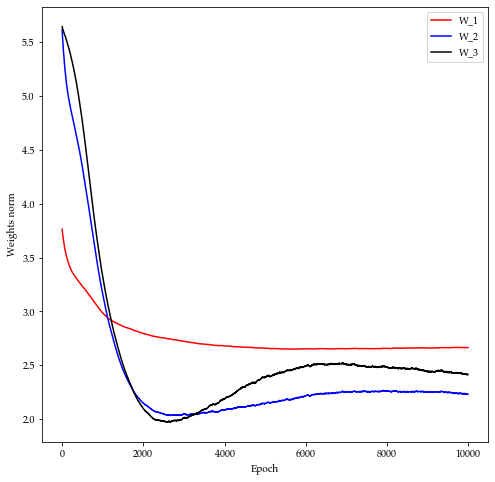

In [149]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(len(W_1_hist)), W_1_hist, 'r',
         np.arange(len(W_2_hist)), W_2_hist, 'b',
         np.arange(len(W_3_hist)), W_3_hist, 'k')
plt.legend(['W_1','W_2', 'W_3'])
plt.xlabel('Epoch'), plt.ylabel('Weights norm')
#plt.ylim(-.0, .06)

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'))

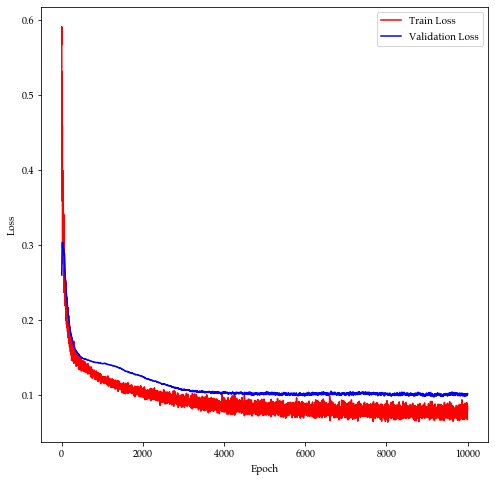

In [150]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(len(train_loss)), train_loss, 'r', np.arange(len(val_loss)), val_loss, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')
#plt.ylim(-.0, .06)

We need to go back from normalization in order to have a better feeling of the results and avoid division for very low numbers.

In [151]:
def reverse_range_norm(x_norm, x_min, x_max):
    """ Inverse of normalization in range [0, 1] """
    x = x_min +  x_norm * (x_max - x_min)

    return x

In [152]:
flag_list = None
model.eval()
train_x = Variable(torch.from_numpy(X_train.astype('float32')))
train_y = Variable(torch.from_numpy(Y_train.astype('float32')))

train_pred = model(train_x)

train_y = reverse_range_norm(train_y.detach().numpy(), y_min, y_max)
train_pred = reverse_range_norm(train_pred.detach().numpy(), y_min, y_max)

err_perc = abs(train_y - train_pred) / (train_y + 1e-12) * 100

if flag_list:
    for i in range(train_y.shape[0]):
        print("True : {:06.2f}, {:06.2f}  |  Prediction : {:06.2f}, {:06.2f}  |  Error : {:07.2f}%, {:07.2f}%".
              format(*train_y[i, :], *train_pred[i, :], *err_perc[i, :]))
    
print("\nThe mean of the percentage error is: {:.2f}%".format(np.mean(err_perc)))


The mean of the percentage error is: 28.23%


In [153]:
flag_list = None
model.eval()
val_x = Variable(torch.from_numpy(X_val.astype('float32')))
val_y = Variable(torch.from_numpy(Y_val.astype('float32')))

val_pred = model(val_x)

val_y = reverse_range_norm(val_y.detach().numpy(), y_min, y_max)
val_pred = reverse_range_norm(val_pred.detach().numpy(), y_min, y_max)

err_perc = abs(val_y - val_pred) / val_y * 100
    
if flag_list:
    for i in range(val_y.shape[0]):
        print("True : {:06.2f}, {:06.2f}  |  Prediction : {:06.2f}, {:06.2f}  |  Error : {:07.2f}%, {:07.2f}%".
              format(*val_y[i, :], *val_pred[i, :], *err_perc[i, :]))
print("\nThe mean of the percentage error is: {:.2f}%".format(np.mean(err_perc)))


The mean of the percentage error is: 40.38%


In [108]:
flag_list = False
testing = False

if testing:
    model.eval()
    test_x = Variable(torch.from_numpy(X_test.astype('float32')))
    test_y = Variable(torch.from_numpy(Y_test.astype('float32')))

    test_pred = model(test_x)
    
    test_y = reverse_range_norm(test_y.detach().numpy(), y_min, y_max)
    test_pred = reverse_range_norm(test_pred.detach().numpy(), y_min, y_max)

    err_perc = abs(test_y - test_pred) / test_y * 100

    if flag_list:
        for i in range(test_y.shape[0]):
            print("True : {:.4f}, {:.4f}  |  Prediction : {:.4f}, {:.4f}  |  Error : {:07.2f}%, {:07.2f}%".
                  format(*test_y[i, :], *test_pred[i, :], *err_perc[i, :]))
    print("\nThe mean of the percentage error is: {:.2f}%".format(np.mean(err_perc)))


The mean of the percentage error is: 29.56%


In [67]:
#for name, param in model.named_parameters():
#    print(name, param)

W_1 Parameter containing:
tensor([[ 1.6076e-01,  2.9201e-02, -2.0080e-02,  1.0035e-01, -7.7736e-02,
         -1.5217e-01, -1.3130e-01,  7.3196e-01],
        [-1.6701e-01, -4.7064e-02, -1.1387e-01,  7.3239e-01, -5.9730e-02,
          4.3083e-02, -1.4083e-01,  9.2516e-02],
        [-1.1790e-01, -6.4568e-03,  2.3158e-01, -7.8901e-01, -5.4922e-02,
         -1.3657e-02, -8.8686e-02, -1.0021e-01],
        [-2.5807e-01,  7.4009e-02,  1.3900e-01,  1.0941e-01,  2.4172e-01,
         -4.1777e-01,  1.8446e-01, -1.4877e-01],
        [ 3.2722e-01,  5.3174e-02,  4.7396e-02,  4.2710e-02,  4.2612e-02,
          3.2857e-02,  1.9792e-01, -4.5342e-01],
        [-1.7791e-01,  3.4020e-01,  1.6824e-01,  1.9266e-02,  1.4444e-01,
         -5.9190e-01, -8.0954e-02, -5.0150e-02],
        [ 1.5275e-02,  3.4952e-02,  2.2964e-01, -4.9752e-01,  2.9095e-01,
         -1.4830e-01,  8.1434e-02, -2.3035e-01],
        [-3.4002e-02, -7.6271e-02, -9.3341e-02,  2.8778e-01,  1.4320e-01,
          4.8959e-02,  1.4918e-01,  2.7